# Gradients $\times$ Input on MNIST

The gradients $\times$ input attribution method produces an image-specific class saliency map which corresponds to the gradient of the output with respect to the input times the input, hence the name "gradients $\times$ input". This method is derived from the standard gradient method, shown in a seperate notebook. Its as simple as the gradient attribution method, but provides clearer results. It can be used with any classification model, since it only depends on the inputs gradients, not any gradients from the hidden layers and the input themselves.

For more technical information on the gradients $\times$ input attribution method see: [Learning Important Features Through Propagating Activation Differences](https://arxiv.org/abs/1704.02685)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax
import flax.linen as nn
import jax
from jax import random
from jax import vmap
from jax import grad
from keras.utils import data_utils

2022-11-01 13:38:28.856462: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-01 13:38:30.276826: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-01 13:38:30.277116: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-01 13:38:30.277125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.csv"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.csv"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(train_data_path, train_data_url)

data_df = pd.read_csv('./digit-recognizer/train.csv')

In [3]:
np.random.shuffle(data_df.values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[1000:]
X_train = X_train / 255.
Y_train = Y[1000:]

X_val = X[:1000]
X_val = X_val / 255.
Y_val = Y[:1000]

### Define the classification model

In [4]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        mlp = nn.Sequential([
            nn.Dense(10), jax.nn.relu,
            nn.Dense(10), jax.nn.softmax        
        ])
        return mlp(x)

# Create eh model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path         ┃ module      ┃ inputs         ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│              │ _forward_fn │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Sequential_0 │ Sequential  │ float32[5,784] │ float32[5,10] │                │
├──────────────┼─────────────┼────────────────┼───────────────┼────────────────┤
│ Dense_0      │ Dense       │ float32[5,784] │ float32[5,10] │ bias:          │
│              │             │                │               │ float32[10]    │
│              │             │                │               │ kernel:        │
│              │             │                │               │ float32[784,1… │
│              │           

### Define the loss function and update method

In [5]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    A2 = forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(A2)) / m
    return loss


def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [6]:
def get_predictions(A2):
    return jnp.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X)
    for i in range(iterations):
        params = update_params(params, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            A2 = forward_fn.apply(params, X)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return params

In [7]:
params = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[1 8 1 ... 3 4 2] [0 9 0 ... 7 5 6]
0.10341463
Iteration:  10
[2 2 2 ... 7 4 6] [0 9 0 ... 7 5 6]
0.36336583
Iteration:  20
[2 6 2 ... 7 3 6] [0 9 0 ... 7 5 6]
0.4545366
Iteration:  30
[8 6 6 ... 7 3 6] [0 9 0 ... 7 5 6]
0.52558535
Iteration:  40
[8 6 6 ... 7 3 6] [0 9 0 ... 7 5 6]
0.5536097
Iteration:  50
[8 6 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.591439
Iteration:  60
[8 6 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.63134146
Iteration:  70
[8 6 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.66212195
Iteration:  80
[8 4 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.68351215
Iteration:  90
[0 4 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.7021463
Iteration:  100
[0 4 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.7175853
Iteration:  110
[0 4 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.7324878
Iteration:  120
[0 4 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.74602437
Iteration:  130
[0 4 0 ... 7 3 6] [0 9 0 ... 7 5 6]
0.7614146
Iteration:  140
[0 4 0 ... 7 5 6] [0 9 0 ... 7 5 6]
0.7744634
Iteration:  150
[0 4 0 ... 7 5 6] [0 9 0 ... 7 5 6]
0.7864146
Iteration:  1

### Display predictions and saliency maps

The jax "grad" function is used to extract the gradients used for the saliency map. The only gradients needed are the input gradients, hence agrnums=1. This is different to how grad is used for training, shown above. When training only the gradients for the models parameters are needed. Its also possible to extract the input gradients while training, which could be useful for debugging. As you can see below the only difference in the code to the standard gradients method is that the gradients are multiplied by the inputs before displaying the saliency map.

In [12]:
def make_predictions(X, params):
    rng = jax.random.PRNGKey(42)
    A2 = forward_fn.apply(params, X)
    predictions = get_predictions(A2)
    return predictions

def extract_gradients(params, X, Y):
    # Calculate the derivative WRT the input image
    grads = grad(loss_fn, argnums=1)(params, X, Y)[0]
    # Multiply gradients by the input
    grads_x_inputs = grads * X

    # Normalize the gradient values to be between 0-1
    max_grad = np.max(grads_x_inputs)
    min_grad = np.min(grads_x_inputs)
    grads_x_inputs = (grads_x_inputs - min_grad) / (max_grad - min_grad)
    # Convert the grads to uint8 for displaying
    grads_x_inputs = np.uint8(grads_x_inputs * 255)
    return grads_x_inputs  

def display_prediction(index, params):
    current_image = X_train[None, index]
    prediction = make_predictions(X_train[None, index], params)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    image_grads = extract_gradients(params, current_image, label)
    image_grads = image_grads.reshape((28, 28))
    plt.gray()
    plt.imshow(image_grads, interpolation='nearest')
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()

Prediction:  [0]
Label:  0


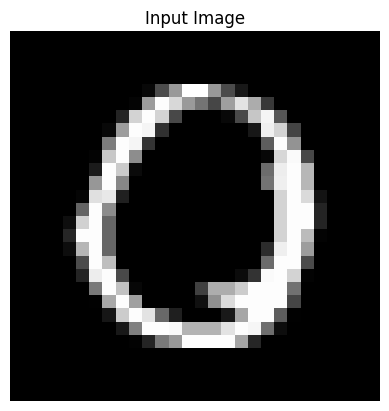

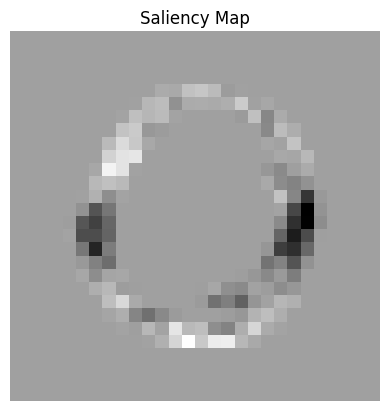

Prediction:  [9]
Label:  9


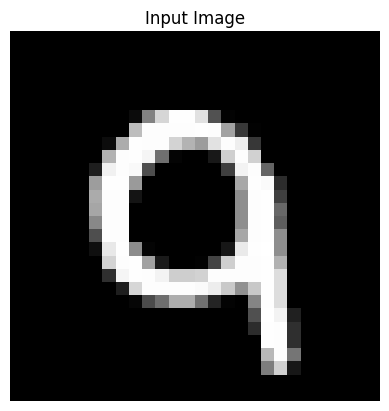

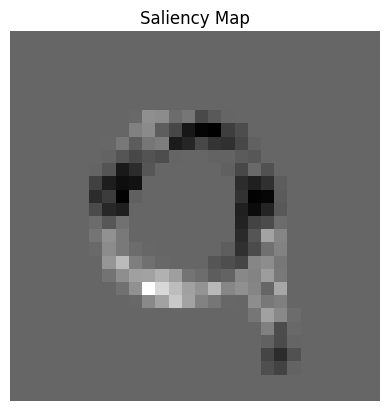

Prediction:  [0]
Label:  0


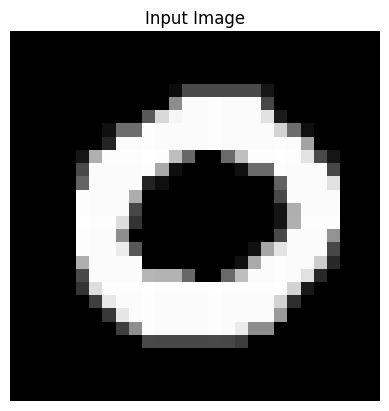

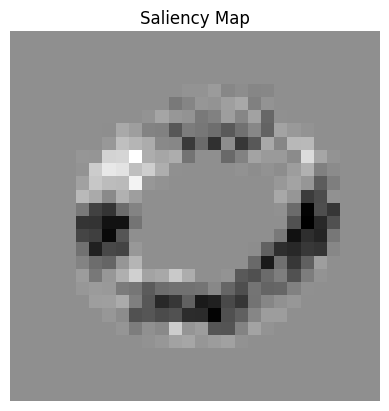

Prediction:  [8]
Label:  8


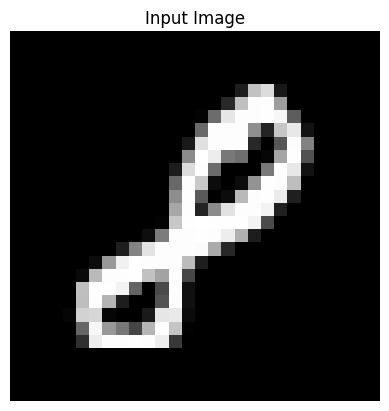

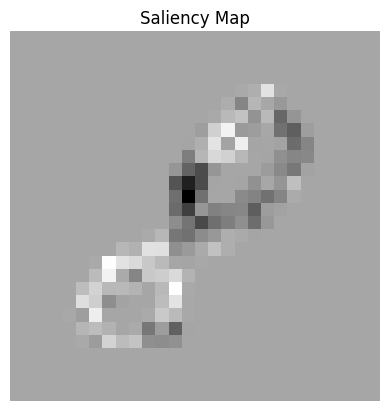

In [13]:
display_prediction(0, params)
display_prediction(1, params)
display_prediction(2, params)
display_prediction(3, params)